# High Growth Firms Prediction

In [194]:
# imports

import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("https://osf.io/download/3qyut/")

In [196]:
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.00,2005-01-01,2005-12-31,NaN,692.59,7266.67,7574.07,0.00,0.00,0.00,...,mix,Domestic,5630.00,56.00,3.00,1,Central,1990-11-19,NaN,NaN
1,1001034.00,2006-01-01,2006-12-31,NaN,603.70,13122.22,12211.11,0.00,0.00,0.00,...,mix,Domestic,5630.00,56.00,3.00,1,Central,1990-11-19,NaN,NaN
2,1001034.00,2007-01-01,2007-12-31,NaN,425.93,8196.30,7800.00,0.00,0.00,0.00,...,mix,Domestic,5630.00,56.00,3.00,1,Central,1990-11-19,NaN,NaN
3,1001034.00,2008-01-01,2008-12-31,NaN,300.00,8485.19,7781.48,0.00,0.00,0.00,...,mix,Domestic,5630.00,56.00,3.00,1,Central,1990-11-19,NaN,NaN
4,1001034.00,2009-01-01,2009-12-31,NaN,207.41,5137.04,15300.00,0.00,0.00,0.00,...,mix,Domestic,5630.00,56.00,3.00,1,Central,1990-11-19,NaN,0.08


## 🧹Data prepreation:

### Filtering year between 2010 and 2015

In [197]:
# Filtering the years to 2010-2015
data = data[(data["year"] >= 2010) & (data["year"] <= 2015)]

### Missing values in columns

In [198]:
# Checking for the missing values in each column

missing_data = pd.DataFrame(data.isnull().sum(), columns=['Missing Values'])
missing_data['Percentage (%)'] = (missing_data['Missing Values'] / len(data)) * 100

# Sort by percentage
missing_data = missing_data.sort_values(by='Percentage (%)', ascending=False). round(2)

# Filter to show only columns that actually have missing data
missing_data = missing_data[missing_data['Missing Values'] > 0]

missing_data

,Missing Values,Percentage (%)
D,167606,100.00
finished_prod,158855,94.78
wages,158707,94.69
COGS,158556,94.60
net_exp_sales,158556,94.60
net_dom_sales,158556,94.60
exit_year,150648,89.88
exit_date,147067,87.75
labor_avg,53346,31.83
birth_year,43221,25.79


In [199]:
# dropping columns with more than 90% missing values:

drop_cols = ["D", "finished_prod", "wages", "COGS", "net_exp_sales", "net_dom_sales"]
data = data.drop(columns=drop_cols)
print('columns dropped.')

columns dropped.


## 🔘 sales

#### zero sales

In [200]:
# Firms with zero sales in 2012 

# Count firms with 0 sales in 2012
subset_2012 = data[data['year'] == 2012]
zero_sales_count = len(subset_2012[subset_2012['sales'] == 0])
total_firms_2012 = len(subset_2012)
# percentage
percent_zero = (zero_sales_count / total_firms_2012) * 100

print(f"Total firms in 2012: {total_firms_2012}")
print(f"Firms with 0 sales: {zero_sales_count}")
print(f"Percentage to drop: {percent_zero:.2f}%") 

Total firms in 2012: 28469
Firms with 0 sales: 4597
Percentage to drop: 16.15%


In [201]:
# dropping the firms with 0 sales in 2012 to avoid getting inf for sales growth
data = data[~((data['year'] == 2012) & (data['sales'] == 0))]
print('✅firms with zero sales in 2012 are dropped.')
print(f"New row count for 2012: {len(data[data['year'] == 2012])}")

✅firms with zero sales in 2012 are dropped.
New row count for 2012: 23872


#### negative sales

In [202]:
# 1. Count firms with negative sales
negative_sales_count = len(data[data['sales'] < 0])
total_firms = len(data)

# 2. Calculate percentage
percent_negative = (negative_sales_count / total_firms) * 100

print(f"Total firms: {total_firms}")
print(f"Firms with negative sales: {negative_sales_count}")
print(f"Percentage to drop: {percent_negative:.4f}%")

Total firms: 163009
Firms with negative sales: 22
Percentage to drop: 0.0135%


In [203]:
data = data[data['sales'] > 0]
print('✅ Firms with nagative sales are dropped')

✅ Firms with nagative sales are dropped


#### Sales growth

In [204]:
# 1. Sort data to ensure years are in order (Crucial for shift to work)
data = data.sort_values(by=['comp_id', 'year'])

# 2. Calculate 2-Year Growth Rate (Sales 2014 - Sales 2012) / Sales 2012
# We use shift(-2) to grab the value from 2 rows ahead (2014) for the current row (2012)
data['sales_growth'] = (
    (data.groupby('comp_id')['sales'].shift(-2) - data['sales']) / data['sales']
)

data[data['year'] == 2012][['comp_id', 'year', 'sales', 'sales_growth']].head()

,comp_id,year,sales,sales_growth
14,1001541.00,2012,1203.70,3.06
23,1002029.00,2012,1136514.88,-0.81
35,1003200.00,2012,2785.19,NaN
56,1011889.00,2012,433666.66,0.09
68,1014183.00,2012,129729.63,-0.22


In [205]:
data['sales_growth'].describe().round(2)

count    71619.00
mean        23.80
std       1462.66
min         -1.00
25%         -0.23
50%          0.09
75%          0.55
max     224966.01
Name: sales_growth, dtype: float64

#### Stats of sales

In [206]:
# Suppress scientific notation and show 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

data['sales'].describe()

count      134978.00
mean       565981.45
std       4168136.28
min             3.70
25%         13725.93
50%         43316.67
75%        141661.12
max     111029448.00
Name: sales, dtype: float64

#### Sales in millions, log and log of millions

In [207]:
# 1. Sales in Millions
data['sales_mil'] = data['sales'] / 1000000

# 2. Log of Sales (Raw)
data['sales_log'] = np.log(data['sales'])

# 3. Log of Sales in Millions
data['sales_mil_log'] = np.log(data['sales_mil'])

print('✅ new variables have been created for sales: sales_mil, sales_log, sales_mil_log')

✅ new variables have been created for sales: sales_mil, sales_log, sales_mil_log


In [208]:
# Check specific percentiles to find the "noise" floor and the "giant" ceiling
percentiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
print(data['sales'].quantile(percentiles))

0.01        185.19
0.05       1406.85
0.10       3618.52
0.25      13725.93
0.50      43316.67
0.75     141661.12
0.90     481580.38
0.95    1217291.46
0.99   10519786.49
Name: sales, dtype: float64


👆🏻 based on the 5th and 99th percentile, i will set the lower limit to 1000 and upper limit to 10 million.

In [209]:
# filtering firms between 1,000 EUR (0.001m) and 10 Million EUR (10m)
data = data.query("sales_mil <= 10 & sales_mil >= 0.001")
print('✅ data has been filtered: 1,000 < sales < 10,000,000')

✅ data has been filtered: 1,000 < sales < 10,000,000


## 🔘 Age  of firms

In [210]:
# 1. Calculate Age (Current Year - Founded Year)
data['age'] = data['year'] - data['founded_year']

# Fix negative ages (Data errors where founded_year > current_year)
data['age'] = np.where(data['age'] < 0, 0, data['age'])

In [211]:
# 2. Create the "New Firm" Dummy (1 = New, 0 = Old)
# A firm is "New" if it is <= 1 year old OR if its balance sheet covers less than a year
# We fill NaNs with 0 (assume "Old" if we don't know, or you can drop them)
data['new'] = np.where(
    (data['age'] <= 1) | (data['balsheet_notfullyear'] == 1),
    1,
    0
)

In [212]:
data['age'] = data['age'].astype('Int64')
data['founded_year'] = data['founded_year'].astype('Int64')

In [213]:
# 3. Check the results
print(data[['year', 'founded_year', 'age', 'new']].head(10))
print("\nNumber of New Firms:", data['new'].sum())

    year  founded_year  age  new
5   2010          1990   20    0
14  2012          2008    4    0
15  2013          2008    5    0
16  2014          2008    6    0
17  2015          2008    7    0
21  2010          2006    4    0
22  2011          2006    5    0
23  2012          2006    6    0
24  2013          2006    7    0
25  2014          2006    8    0

Number of New Firms: 21359


## 🔘 Industry category

In [214]:
import numpy as np

# 1. copy of the original industry code (ind2)
data['ind2_cat'] = data['ind2'].copy()

# 2. Group High-Tech & Services (Codes > 56 become '60')
# Likely captures: IT, Consultancy, Scientific Research, etc.
data['ind2_cat'] = np.where(data['ind2'] > 56, 60, data['ind2_cat'])

# 3. Group Manufacturing & Heavy Industry (Codes < 26 become '20')
# Likely captures: Food, Textiles, Wood, Chemicals, etc.
data['ind2_cat'] = np.where(data['ind2'] < 26, 20, data['ind2_cat'])

# 4. Group Energy, Water, Construction (Codes 36-54 become '40')
# Likely captures: Energy supply, Water/Waste management, Construction.
data['ind2_cat'] = np.where(
    (data['ind2'] < 55) & (data['ind2'] > 35), 40, data['ind2_cat']
)

# 5. Group Manufacturing of Furniture/Other (Code 31 becomes '30')
# Specific adjustment for a distinct category (often Furniture or "Other Manufacturing").
data['ind2_cat'] = np.where(data['ind2'] == 31, 30, data['ind2_cat'])

# 6. Handle Missing Values (NaN becomes '99')
# Instead of dropping firms with unknown industries, we group them into an "Unknown" category.
data['ind2_cat'] = np.where(data['ind2'].isna(), 99, data['ind2_cat'])

# 7. Check the new distribution
print(data['ind2_cat'].value_counts().sort_index())

ind2_cat
20.00      310
26.00     6428
27.00     3898
28.00    11606
29.00     1703
30.00     1017
32.00      829
33.00    11371
35.00        2
40.00     1250
55.00    13637
56.00    74806
60.00     1460
99.00       38
Name: count, dtype: int64


## 🔘 Firm characteristics

### Age:

In [215]:
# 1. Create Quadratic Age (Age^2)
data['age2'] = data['age'] ** 2

### Foreign Management:

In [216]:
# 2. Create Binary Foreign Management Dummy

# If >= 0.5 (50%) "Foreign Managed" (1).
# If < 0.5,  "Domestic" (0).
# If missing (NaN), we keep it as NaN to handle later.
data['foreign_management'] = np.where(
    data['foreign'] >= 0.5, 
    1, 
    np.where(data['foreign'].isna(), np.nan, 0)
)

### Gender of the CEO:

In [217]:
# gender
data['gender'].unique()

array(['mix', 'male', 'female', nan], dtype=object)

In [218]:
# 1. Handle Missing Values
# Instead of deleting them, we label them 'unknown' so we can track them.
data['gender'] = data['gender'].fillna('unknown')

# 2. Convert to Category
data['gender_cat'] = data['gender'].astype('category')

# 3. Create Dummy Variables 
# baseline:male

# dummy for Female CEOs
data['gender_female'] = np.where(data['gender'] == 'female', 1, 0)

# dummy for Mixed Gender Boards
data['gender_mix'] = np.where(data['gender'] == 'mix', 1, 0)

# dummy for Unknown Gender (Optional, but good to have)
data['gender_unknown'] = np.where(data['gender'] == 'unknown', 1, 0)


# 4. Check the result
print(data[['gender', 'gender_female', 'gender_mix', 'gender_unknown']].value_counts())

gender   gender_female  gender_mix  gender_unknown
male     0              0           0                 79780
female   1              0           0                 23592
mix      0              1           0                 13292
unknown  0              0           1                 11691
Name: count, dtype: int64


### CEU Age:

In [219]:
# 1. Calculate CEO Age
data["ceo_age"] = data["year"] - data["birth_year"]

# 2. Create Flags for Outliers and Missing Data
data = data.assign(
    flag_low_ceo_age = (data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age = (data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age = (data["ceo_age"].isna()).astype(int),
)

# 3. Winsorize (Clip) the Ages
# If < 25, make it 25. 
data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
# If > 75, make it 75.
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])

# 4. Impute Missing Values
# Fill NaNs with the average age of the valid (clipped) CEOs.
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), 
    data["ceo_age"].mean(), 
    data["ceo_age"]
)

# 5. Create "Young CEO" Dummy
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

# 6. Check the result
print(data[['ceo_age', 'flag_miss_ceo_age', 'ceo_young']].describe())

        ceo_age  flag_miss_ceo_age  ceo_young
count 128355.00          128355.00  128355.00
mean      47.04               0.22       0.23
std       10.02               0.41       0.42
min       25.00               0.00       0.00
25%       40.00               0.00       0.00
50%       47.04               0.00       0.00
75%       53.00               0.00       0.00
max       75.00               1.00       1.00


### Region:

In [220]:
data['region_m'].unique()

array(['Central', 'East', 'West', nan], dtype=object)

In [221]:
# 1. Handle Missing Values
data['region_m'] = data['region_m'].fillna('unknown')

# 2. Create Dummy Variables
# We assume 'Central' is the baseline

# dummy for East Region
data['region_east'] = np.where(data['region_m'] == 'East', 1, 0)

# dummy for West Region
data['region_west'] = np.where(data['region_m'] == 'West', 1, 0)

# dummy for Unknown Region
data['region_unknown'] = np.where(data['region_m'] == 'unknown', 1, 0)

# 3. Drop the original text column if you want (optional)
# data = data.drop(columns=['region_m']) 

# 4. Check the result
print(data[['region_m', 'region_east', 'region_west', 'region_unknown']].value_counts())

region_m  region_east  region_west  region_unknown
Central   0            0            0                 76845
East      1            0            0                 31901
West      0            1            0                 19259
unknown   0            0            1                   350
Name: count, dtype: int64


In [222]:
# 1. Create flags for the other locations (Baseline is Category 1: Big City)
data["urban_town"] = np.where(data["urban_m"] == 2, 1, 0)
data["urban_rural"] = np.where(data["urban_m"] == 3, 1, 0)

# 2. Handle potential missing values (NaNs)
# If the original urban_m was NaN, make the dummies NaN too
data.loc[data["urban_m"].isna(), ["urban_town", "urban_rural"]] = np.nan

# 3. Check the result
print(data[["urban_m", "urban_town", "urban_rural"]].head(10))

    urban_m  urban_town  urban_rural
5         1        0.00         0.00
14        3        0.00         1.00
15        3        0.00         1.00
16        3        0.00         1.00
17        3        0.00         1.00
21        3        0.00         1.00
22        3        0.00         1.00
23        3        0.00         1.00
24        3        0.00         1.00
25        3        0.00         1.00


In [223]:
# 3. Create Industry Dummies
# This is better for  Random Forest than just using .astype("category")
data = pd.get_dummies(data, columns=["ind2_cat"], prefix="ind", drop_first=True)

# 4. Check results
print(data["urban_m"].head())

5     1
14    3
15    3
16    3
17    3
Name: urban_m, dtype: int64


## 🔘average number of employees (labor force)

In [224]:
# 1. Create a flag BEFORE imputation
# This remembers which firms had missing data, which can itself be a predictor
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

# 2. Create the modified version (Imputation)
# Fill NaNs with the mean so the model can run without crashing
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), 
    data["labor_avg"].mean(), 
    data["labor_avg"]
)

# 3. NEW: Calculate Labor Growth (Momentum)
# We calculate the change in employees from the previous year for each firm
data['labor_growth_lag'] = data.groupby('comp_id')['labor_avg_mod'].diff()
# Fill the first year for each firm with 0 to avoid new NaNs
data['labor_growth_lag'] = data['labor_growth_lag'].fillna(0)

# 4. Check the statistics
print("Original Labor Stats:")
print(data["labor_avg"].describe())
print("\nModified Labor Stats (No NaNs):")
print(data["labor_avg_mod"].describe())
print("\nLabor Growth (Momentum) Stats:")
print(data["labor_growth_lag"].describe())

# 5. Drop the original noisy variable
data = data.drop(["labor_avg"], axis=1)

Original Labor Stats:
count   104401.00
mean         0.67
std          1.71
min          0.00
25%          0.11
50%          0.25
75%          0.57
max         64.58
Name: labor_avg, dtype: float64

Modified Labor Stats (No NaNs):
count   128355.00
mean         0.67
std          1.54
min          0.00
25%          0.15
50%          0.34
75%          0.67
max         64.58
Name: labor_avg_mod, dtype: float64

Labor Growth (Momentum) Stats:
count   128355.00
mean         0.00
std          0.39
min        -28.27
25%          0.00
50%          0.00
75%          0.01
max         63.89
Name: labor_growth_lag, dtype: float64


## 🔘 Assets

In [225]:
# 1. Create the "Red Flag" for negative assets
data["flag_asset_problem"] = np.where(
    (data["intang_assets"] < 0) | 
    (data["curr_assets"] < 0) | 
    (data["fixed_assets"] < 0),
    1,
    0
)

# 2. Handle Missing Values (NaN)
data["flag_asset_problem"] = np.where(
    (data["intang_assets"].isna()) | 
    (data["curr_assets"].isna()) | 
    (data["fixed_assets"].isna()),
    np.nan,
    data["flag_asset_problem"]
)

# 3. FIX the Negative Values (Change them to 0)
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"]   = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"]  = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

# 4. Check the result
print(data.groupby("flag_asset_problem").count()["comp_id"])

flag_asset_problem
0.00    128260
1.00        65
Name: comp_id, dtype: int64


In [226]:
# 1. Generate Total Assets (Balance Sheet)
# Sum of Intangible, Current, and Fixed Assets
data["total_assets_bs"] = (
    data["intang_assets"] + 
    data["curr_assets"] + 
    data["fixed_assets"]
)

# 2. Calculate Asset Growth (Investment Capacity)
data['asset_growth_lag'] = data.groupby('comp_id')['total_assets_bs'].pct_change()

# 3. Clean the Growth Variable
# Replace infinities (caused by dividing by zero assets) and NaNs with 0
data['asset_growth_lag'] = data['asset_growth_lag'].replace([np.inf, -np.inf, np.nan], 0)

# 4. Check the distribution
print("Total Assets Stats:")
print(data["total_assets_bs"].describe())
print("\nAsset Growth (Momentum) Stats:")
print(data["asset_growth_lag"].describe())

Total Assets Stats:
count      128325.00
mean       271562.41
std       1875274.47
min             0.00
25%          7577.78
50%         26355.56
75%        103722.22
max     319069129.03
Name: total_assets_bs, dtype: float64

Asset Growth (Momentum) Stats:
count   128355.00
mean         0.87
std         39.07
min         -1.00
25%         -0.06
50%          0.00
75%          0.14
max       8790.67
Name: asset_growth_lag, dtype: float64


/var/folders/px/j0g00nkx0pl9hr2wph6gdt9r0000gn/T/ipykernel_81515/2804607683.py:10: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['asset_growth_lag'] = data.groupby('comp_id')['total_assets_bs'].pct_change()


## 🔘 normalizing financial variables:

In [227]:
# -------------------------------------------------------------------------
# 1. Define Variable Groups
# -------------------------------------------------------------------------
pl_names = [
    "extra_exp", "extra_inc", "extra_profit_loss", "inc_bef_tax",
    "inventories", "material_exp", "profit_loss_year", "personnel_exp"
]
bs_names = [
    "intang_assets", "curr_liab", "fixed_assets", "liq_assets",
    "curr_assets", "share_eq", "subscribed_cap", "tang_assets"
]

# -------------------------------------------------------------------------
# 2. Create Ratios
# -------------------------------------------------------------------------

# A. Profit & Loss Ratios (Divide by Sales)
# Creates columns like 'personnel_exp_pl'
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

# B. Balance Sheet Ratios (Divide by Total Assets)
# Creates columns like 'curr_assets_bs'
# We handle division by zero/NaN immediately by replacing result with 0
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)

# C. Correct for originally missing Total Assets
# If total_assets_bs was NaN, we want the ratio to be NaN (not 0)
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), 
        np.nan, 
        data[col + "_bs"]
    )

In [228]:
# -------------------------------------------------------------------------
# 3. Winsorizing & Flagging (Handling Outliers)
# -------------------------------------------------------------------------

# Group 1: Variables that SHOULD be positive (mostly 0 to 1)
# e.g., "Materials as % of Sales" or "Fixed Assets as % of Total Assets"
zero = [
    "extra_exp_pl", "extra_inc_pl", "inventories_pl", "material_exp_pl", 
    "personnel_exp_pl", "curr_liab_bs", "fixed_assets_bs", "liq_assets_bs", 
    "curr_assets_bs", "subscribed_cap_bs", "intang_assets_bs"
]

# A. Flag and Clip High Values (> 1)
data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[zero] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)

# B. Flag and Clip Negative Errors (< 0)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[zero] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

# Group 2: Variables that can be positive or negative (Range -1 to 1)
# e.g., Profit Margins or Shareholder Equity
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

# A. Flag and Clip Low Values (< -1)
data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[anyof] = np.where(
    data[anyof].isna(), np.nan, np.where(data[anyof] < -1, -1, data[anyof])
)

# B. Flag and Clip High Values (> 1)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[anyof] = np.where(
    data[anyof].isna(), np.nan, np.where(data[anyof] > 1, 1, data[anyof])
)

# C. Flag Exact Zeros
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)

# D. Create Quadratic Term (Value squared)
# Helps capture non-linear effects (e.g. huge losses vs huge gains)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

# -------------------------------------------------------------------------
# Check results
print("Winsorizing complete.")
print(data[['personnel_exp_pl', 'personnel_exp_pl_flag_high']].describe())

Winsorizing complete.
       personnel_exp_pl  personnel_exp_pl_flag_high
count         128136.00                   128136.00
mean               0.29                        0.03
std                0.24                        0.18
min                0.00                        0.00
25%                0.12                        0.00
50%                0.24                        0.00
75%                0.39                        0.00
max                1.00                        1.00


------

# 📊 Exploratory Data Analysis & Feature Visualization

## 🔘 Sales growth

In [229]:
# 1. Calculate the core descriptive statistics and percentiles
stats = data['sales_growth'].describe(percentiles=[.01, .05, .25, .5, .75, .9, .95, .99])
stats_df = pd.DataFrame(stats).transpose()

# 2. Rename columns for a professional appearance
stats_df.columns = [c.capitalize() if isinstance(c, str) else f"{int(c*100)}th Pctl" for c in stats_df.columns]

# 3. Apply the "Neat & Narrow" formatting
styled_table = stats_df.style \
    .format("{:,.2f}") \
    .set_caption("Descriptive Statistics of 2-Year Sales Growth") \
    .hide(axis="index") \
    .set_table_styles([
        # Caption: Bold and centered
        {'selector': 'caption', 'props': [('color', 'black'), ('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding-bottom', '10px')]},
        # Headers: Smaller font and tight padding to prevent wrapping
        {'selector': 'th', 'props': [('border-bottom', '1.5pt solid black'), ('border-top', '1.5pt solid black'), 
                                     ('text-align', 'center'), ('font-weight', 'bold'), ('padding', '4px 8px'), 
                                     ('font-size', '10pt'), ('white-space', 'nowrap')]},
        # Data cells: Smaller font and centered
        {'selector': 'td', 'props': [('padding', '6px 8px'), ('text-align', 'center'), 
                                     ('border-bottom', '1pt solid #eeeeee'), ('font-size', '10pt'), ('white-space', 'nowrap')]},
        # General Table: Ensure it doesn't stretch too wide
        {'selector': '', 'props': [('border-collapse', 'collapse'), ('border', 'none'), ('margin', 'auto'), ('width', 'auto')]}
    ])

# Display the neat table
styled_table

Count,Mean,Std,Min,1%,5%,25%,50%,75%,90%,95%,99%,Max
"68,840.00",1.90,42.17,-1.00,-0.98,-0.83,-0.24,0.08,0.51,1.71,4.14,24.08,"5,096.17"


In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define a Sophisticated Color Palette
# A corporate blue and orange palette
colors = ["#1a4e66", "#e6842a", "#13b0da", "#8c2633", "#71850b"]
sns.set_palette(sns.color_palette(colors))

# 2. Set the Global Style
sns.set_style("whitegrid", {
    "axes.facecolor": "#f9f9f9",
    "grid.color": "#e0e0e0",
    "grid.linestyle": "--",
    "axes.edgecolor": "#333333",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# 3. Set Professional Font & Title Context
sns.set_context("notebook", font_scale=1.2, rc={
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 25,
    "axes.labelsize": 11,
    "axes.labelpad": 15,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

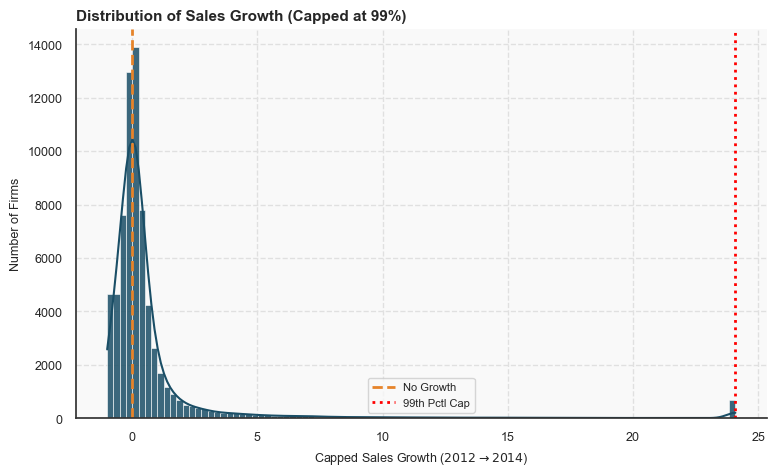

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create the column (The missing step causing your error)
# We calculate the 99th percentile and cap the data
upper_limit_99 = data['sales_growth'].quantile(0.99)
data['sales_growth_clean'] = data['sales_growth'].clip(lower=-1, upper=upper_limit_99)

# 2. Now run your visualization code
plt.figure(figsize=(8, 5))

sns.histplot(
    data=data, 
    x='sales_growth_clean',   
    bins=100,                 
    kde=True,
    color="#1a4e66",
    edgecolor="white",
    alpha=0.85
)

# Professional lines using the calculated 99% limit
plt.axvline(0, color='#e6842a', linestyle='--', linewidth=2, label='No Growth')
plt.axvline(upper_limit_99, color='red', linestyle=':', linewidth=2, label='99th Pctl Cap')

# Formatting
plt.title('Distribution of Sales Growth (Capped at 99%)', loc='left', fontsize=11, fontweight='bold')
plt.xlabel(r'Capped Sales Growth ($2012 \rightarrow 2014$)', fontsize=9)
plt.ylabel('Number of Firms', fontsize=9)

plt.legend(fontsize=8)
plt.tight_layout()

plt.show()

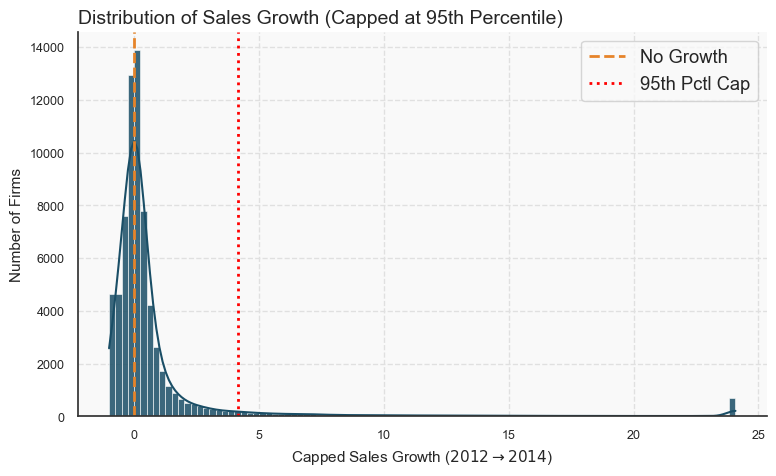

In [233]:
# 4. Visualization of the CLEANED data
# Increasing the size slightly (8, 5) often looks better when pasted into Word
plt.figure(figsize=(8, 5))

sns.histplot(
    data=data, 
    x='sales_growth_clean',   # Using the cleaned variable
    bins=100,                 
    kde=True,
    color="#1a4e66",
    edgecolor="white",
    alpha=0.85
)

# Professional baseline and capping line
plt.axvline(0, color='#e6842a', linestyle='--', linewidth=2, label='No Growth')

# Ensure this matches your chosen limit (e.g., upper_limit_95)
plt.axvline(upper_limit_95, color='red', linestyle=':', linewidth=2, label='95th Pctl Cap')

plt.legend(fontsize=7, loc='upper right')

plt.title('Distribution of Sales Growth (Capped at 95th Percentile)', loc='left')

# Raw string 'r' handles the LaTeX \rightarrow correctly
plt.xlabel(r'Capped Sales Growth ($2012 \rightarrow 2014$)') 
plt.ylabel('Number of Firms')
plt.legend()


plt.tight_layout()


plt.show()

#### 👆🏻 based on these 2 plots, I decided to cap sales growth at 95th percentile

In [236]:
# 1. Define the 95th percentile limit
upper_limit_95 = data['sales_growth'].quantile(0.95)

# 2. Permanent Capping (Winsorizing)
# We overwrite or create the 'clean' column permanently
data['sales_growth_clean'] = data['sales_growth'].clip(lower=-1, upper=upper_limit_95)

# 3. Permanent Outlier Flag (to keep the "Super-Grower" information)
data['flag_growth_outlier'] = (data['sales_growth'] > upper_limit_95).astype(int)

# 4. Final target creation (using your informed decision of 50% growth)
data['target_fast_growth'] = (data['sales_growth_clean'] >= 0.50).astype(int)

print(f"✅ Data finalized with 95th percentile cap at: {upper_limit_95:.2f}")
print(f"✅ Total firms marked as Fast Growth (1): {data['target_fast_growth'].sum()}")

✅ Data finalized with 95th percentile cap at: 4.14
✅ Total firms marked as Fast Growth (1): 17466


## 🔘 defining a classification target

### Percentile Analysis of Capped Data

In [238]:
# Detailed percentiles of the cleaned data
clean_stats = data['sales_growth_clean'].describe(percentiles=[.25, .5, .75, .8, .9, .95])
print("--- Cleaned Growth Percentiles ---")
clean_stats

--- Cleaned Growth Percentiles ---


count   68840.00
mean        0.38
std         1.16
min        -1.00
25%        -0.24
50%         0.08
75%         0.51
80%         0.71
90%         1.71
95%         4.14
max         4.14
Name: sales_growth_clean, dtype: float64

### The Decision Matrix & Class Balance Test

In [240]:
# Test 4 logical business thresholds
test_thresholds = [0.20, 0.50, 1.00, 2.00]
balance_results = []

for t in test_thresholds:
    count_1 = (data['sales_growth_clean'] >= t).sum()
    perc_1 = (data['sales_growth_clean'] >= t).mean() * 100
    balance_results.append({
        "Threshold": f"{int(t*100)}% Growth",
        "Number of 1s": count_1,
        "Class Balance (%)": f"{perc_1:.1f}%"
    })

# Display as a neat DataFrame
balance_df = pd.DataFrame(balance_results)
print("\n--- Class Balance Decision Matrix ---")
balance_df


--- Class Balance Decision Matrix ---


,Threshold,Number of 1s,Class Balance (%)
0,20% Growth,27633,21.5%
1,50% Growth,17466,13.6%
2,100% Growth,10549,8.2%
3,200% Growth,6126,4.8%


In [243]:
# Test 4 logical business thresholds
test_thresholds = [0.20, 0.50, 1.00, 2.00]
balance_results = []
total_firms = len(data)

for t in test_thresholds:
    count_1 = (data['sales_growth_clean'] >= t).sum()
    perc_1 = (data['sales_growth_clean'] >= t).mean() * 100
    
    balance_results.append({
        "Threshold Value": t,
        "Growth %": f"{int(t*100)}%",
        "Number of 1s": count_1,
        "Class Balance": f"{perc_1:.1f}%",
        "Rank": f"Top {perc_1:.1f}% of Firms"  # In this context, Class Balance IS the Rank
    })

# Display as a neat DataFrame
balance_df = pd.DataFrame(balance_results)
print("\n--- Class Balance & Percentile Decision Matrix ---")
balance_df


--- Class Balance & Percentile Decision Matrix ---


,Threshold Value,Growth %,Number of 1s,Class Balance,Rank
0,0.20,20%,27633,21.5%,Top 21.5% of Firms
1,0.50,50%,17466,13.6%,Top 13.6% of Firms
2,1.00,100%,10549,8.2%,Top 8.2% of Firms
3,2.00,200%,6126,4.8%,Top 4.8% of Firms


### 👆🏻 **Target Variable Definition: Fast Growth**

* **Threshold:** Selected **50% cumulative sales growth** as the cutoff for the binary target variable.
* **Economic Significance:** Captures a distinct group of high-performers (**Top 13.6%** of firms) rather than general market trends.
* **Statistical Balance:** Provides a robust "Sweet Spot" for modeling—selective enough to be meaningful, yet balanced enough to prevent model bias toward the majority class (**86.4%** non-growth).
* **Outcome:** Firms meeting this threshold are labeled **1** (Fast Growth), while all others are labeled **0**.

In [245]:
# 1. Create the final binary target
data['target_fast_growth'] = (data['sales_growth_clean'] >= 0.50).astype(int)


print("Target Balance confirmed:")
data['target_fast_growth'].value_counts(normalize=True)

Target Balance confirmed:


target_fast_growth
0   0.86
1   0.14
Name: proportion, dtype: float64

### 🔘 Functional Form: Relationship Between Firm Size and Fast Growth

Note: Binned scatter averages used for computational efficiency instead of raw LOESS to handle the large sample size.

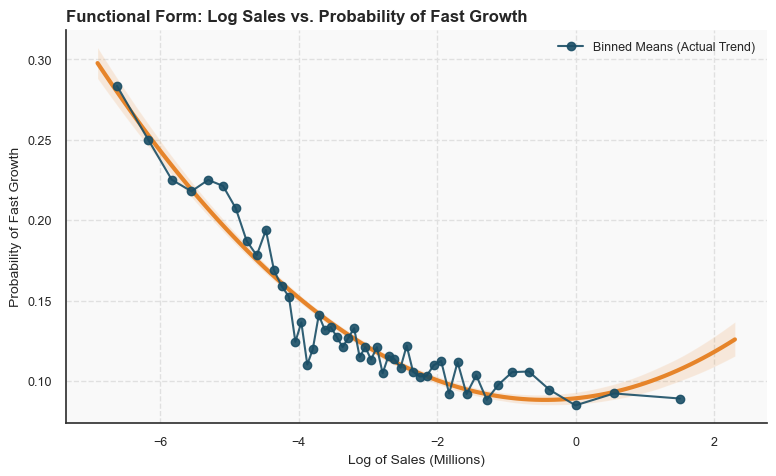

In [ ]:
# 1. Create 50 equal-sized bins based on Sales (the "X" axis)
data['sales_bin'] = pd.qcut(data['sales_mil_log'], 50, labels=False, duplicates='drop')

# 2. Calculate the mean of x and y for each bin
bin_means = data.groupby('sales_bin')[['sales_mil_log', 'target_fast_growth']].mean()

plt.figure(figsize=(8, 5))

# 3. Quadratic Fit (Model Line) 
# Using Orange (#e6842a) to match your previous baseline/reference colors
sns.regplot(
    data=data, 
    x="sales_mil_log", 
    y="target_fast_growth", 
    order=2, 
    scatter=False, 
    line_kws={'color': '#e6842a', 'linewidth': 3, 'label': 'Quadratic Fit'}
)

# 4. Binned Scatter (Actual Trend) 
# Using Dark Blue (#1a4e66) to match your histogram color
plt.plot(
    bin_means['sales_mil_log'], 
    bin_means['target_fast_growth'], 
    marker='o', 
    markersize=6, 
    linestyle='-', 
    color='#1a4e66', 
    label='Binned Means (Actual Trend)', 
    alpha=0.9
)


plt.title('Functional Form: Log Sales vs. Probability of Fast Growth', loc='left', fontsize=12, fontweight='bold')
plt.xlabel('Log of Sales (Millions)', fontsize=10)
plt.ylabel('Probability of Fast Growth', fontsize=10)

# Legend and clean axis
plt.legend(fontsize=9, frameon=False)
sns.despine() # Removes top and right borders
plt.tight_layout()

plt.show()

👆🏻 The binned means (blue dots) follow the quadratic fit (orange line) quite closely. This confirms that the relationship between log sales and the probability of fast growth is non-linear—specifically, the probability of fast growth tends to change differently as firms scale. Because of this strong visual evidence, we will include the squared term (sales_mil_log_sq) in our upcoming Logistic and Random Forest models to better capture this curvature.

In [252]:
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

## 🔘 Cross-Sectional Alignment (2012–2014)

To predict growth, the panel data was transformed into a cross-sectional format. We defined 2012 as the base year for all predictor variables (X) and 2014 as the outcome year to observe the sales growth (y).

- Growth Calculation: Sales growth was calculated as the log difference between 2014 and 2012.

- Applying the Threshold: Following our established criteria, firms that achieved at least 50% cumulative growth (after clipping extreme outliers to prevent model distortion) were labeled as Fast Growth (1).

- Predictive Integrity: By anchoring all features in 2012, we ensure the model is purely predictive—using only information available at the start of the period to forecast the future outcome.

In [254]:
# 1. Create a dataframe that only contains the information from 2012 (our prediction base)
model_data = data[data['year'] == 2012].copy()

# 2. We need to "reach into the future" to get the 2014 sales for these specific firms
# We create a mapping of comp_id to their 2014 sales
sales_2014 = data[data['year'] == 2014][['comp_id', 'sales']].rename(columns={'sales': 'sales_2014'})

# 3. Merge that future info into our 2012 data
model_data = model_data.merge(sales_2014, on='comp_id', how='left')

# 4. Handle missing 2014 sales (if they disappeared, they didn't grow)
model_data['sales_2014'] = model_data['sales_2014'].fillna(0)

In [255]:
# Create the 2-year growth rate
model_data['growth_12_14'] = np.log(model_data['sales_2014'] + 1) - np.log(model_data['sales'] + 1)

# Clip and Flag (The Gabor Methodology)
model_data["flag_low_growth"] = np.where(model_data["growth_12_14"] < -1.5, 1, 0)
model_data["flag_high_growth"] = np.where(model_data["growth_12_14"] > 1.5, 1, 0)
model_data["growth_mod"] = model_data["growth_12_14"].clip(lower=-1.5, upper=1.5)

# Define Target: 1 if growth >= 50%
model_data['target_fast_growth'] = (model_data['growth_mod'] >= 0.50).astype(int)

print(f"Final modeling dataset created with {len(model_data)} firms.")

Final modeling dataset created with 21723 firms.


In [256]:
model_data.head()

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,sales_growth_clean,flag_growth_outlier,target_fast_growth,sales_bin,sales_mil_log_sq,sales_2014,growth_12_14,flag_low_growth,flag_high_growth,growth_mod
0,1001541.00,2012-01-01,2012-12-31,481.48,9629.63,1303.70,0.00,0.00,0.00,190566.67,...,3.06,0,1,0,45.19,4888.89,1.40,0,0,1.40
1,1002029.00,2012-01-01,2012-12-31,14929.63,203885.19,120444.45,0.00,0.00,0.00,23459.26,...,-0.81,0,0,47,0.02,216751.86,-1.66,1,0,-1.50
2,1003200.00,2012-01-01,2012-12-31,25.93,22.22,10996.30,0.00,0.00,0.00,0.00,...,NaN,0,0,2,34.61,0.00,-7.93,1,0,-1.50
3,1011889.00,2012-01-01,2012-12-31,36625.93,160166.67,18911.11,0.00,0.00,0.00,933574.06,...,0.09,0,0,44,0.70,472859.25,0.09,0,0,0.09
4,1014183.00,2012-01-01,2012-12-31,12551.85,199903.70,8274.07,0.00,7.41,7.41,118229.63,...,-0.22,0,0,36,4.17,101051.85,-0.25,0,0,-0.25


In [261]:
# 1. Define the essential list
essentials = ['target_fast_growth', 'sales_mil_log', 'ind2', 'region_m', 'age']

# 2. Count missing values
missing_counts = model_data[essentials].isnull().sum()

# 3. Calculate percentage missing
missing_pct = (model_data[essentials].isnull().sum() / len(model_data)) * 100

# 4. Create a nice summary table
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage (%)': missing_pct.round(2)
})

print("--- MISSING VALUES IN ESSENTIAL VARIABLES ---")
print(missing_summary)

--- MISSING VALUES IN ESSENTIAL VARIABLES ---
                    Missing Count  Percentage (%)
target_fast_growth              0            0.00
sales_mil_log                   0            0.00
ind2                            5            0.02
region_m                        0            0.00
age                          2010            9.25


In [ ]:
# 1. Drop rows where 'age' is missing
model_data = model_data.dropna(subset=['age'])

# 2. Drop the 5 rows missing 'ind2' 
model_data = model_data.dropna(subset=['ind2'])

# 3. Verify the new size of your dataset
print(f"Rows remaining after dropping missing age/ind2: {len(model_data)}")

Rows remaining after dropping missing age/ind2: 19713


-----
## PART I: Probability prediction
----


### Model buliding:

### Data split:

In [263]:
from sklearn.model_selection import train_test_split

# 1. Define your feature sets (M1 to M3 as a start)
# M1: Basic demographics
m1 = ['sales_mil_log', 'sales_mil_log_sq', 'age', 'new']

# M2: M1 + Industry and Region (Fixed Effects)
# Note: Use the column names exactly as they appeared in your 'list' earlier
m2 = m1 + ['ind2', 'region_m', 'foreign']

# M3: M2 + Financial Indicators (The 'Clip and Flag' variables)
# Adjust these names based on your actual list (e.g., 'profit_loss_year_pl')
m3 = m2 + ['profit_loss_year_pl', 'liq_assets_bs', 'curr_assets_bs']


# 2. Perform the Split (80% Train, 20% Test)
# random_state=42 ensures you get the same split every time you run it
train_data, test_data = train_test_split(model_data, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 15770
Test set size: 3943


### Models:

In [277]:
# M1: Basic (Size, Growth, Profit, Industry)
# We use C(ind2) to treat industry as a category
m1 = ['sales_mil_log', 'sales_mil_log_sq', 'profit_loss_year_pl', 'C(ind2)']

# M2: M1 + Assets, Age, and Foreign Management
m2 = m1 + ['fixed_assets', 'share_eq', 'curr_liab', 'age', 'foreign', 'C(region_m)']

# M3: M2 + More Financials
m3 = m2 + ['liq_assets', 'curr_assets', 'intang_assets', 'inventories']

# M4: Full Model (M3 + Demographics)
m4 = m3 + ['ceo_age', 'female', 'ceo_count']

# M5: The Interaction Model (M4 + specific logic)
# Note: Patsy handles interactions with the '*' or ':' operator automatically
m5 = m4 + ['C(ind2):sales_mil_log', 'C(ind2):age', 'sales_mil_log:age']

### Cross-Validation (K-Fold):

In [278]:
from sklearn.model_selection import KFold

# Specify 5-fold cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

In [281]:
import patsy
from sklearn.linear_model import LogisticRegressionCV

# Group the models for the loop
logit_model_vars = [m1, m2, m3, m4, m5]
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):
    # Create the formula for patsy
    model_equation = "target_fast_growth ~ " + " + ".join(model_vars)
    
    # Prepare X and y (patsy handles the dummies for C() variables)
    y, X = patsy.dmatrices(model_equation, train_data)

    # Logit with NO regularization (C is very high)
    LRCV_brier = LogisticRegressionCV(
        Cs=[1e20], 
        cv=k, 
        refit=True, 
        scoring="neg_brier_score", 
        solver="newton-cg", 
        random_state=42
    )

    model_name = "M" + str(i + 1)
    logit_models[model_name] = LRCV_brier.fit(X, y.ravel())

    # Calculate RMSE from the Brier Score for each of the 5 folds
    CV_RMSE_folds[model_name] = np.sqrt(-1 * logit_models[model_name].scores_[1.0].ravel())

# Create the summary table
cv_results_df = pd.DataFrame(CV_RMSE_folds)
print("RMSE across 5 folds:")
cv_results_df

/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/optimize.py:319: ConvergenceWarning: newton-cg failed to converge at loss = 0.4474480383799763. Increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/opt/anaconda3/lib/python3.13/site-package

RMSE across 5 folds:


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/optimize.py:319: ConvergenceWarning: newton-cg failed to converge at loss = 0.4325644974639662. Increase the number of iterations.
  warnings.warn(


,M1,M2,M3,M4,M5
0,0.37,0.37,0.37,0.37,0.37
1,0.37,0.37,0.37,0.37,0.37
2,0.38,0.38,0.38,0.38,0.38
3,0.37,0.37,0.37,0.37,0.37
4,0.38,0.37,0.38,0.38,0.38


In [282]:
print("\nAverage CV RMSE:")
cv_results_df.mean()


Average CV RMSE:


M1   0.37
M2   0.37
M3   0.37
M4   0.37
M5   0.37
dtype: float64

In [283]:
# 1. Check if the coefficients are all zero
for name, model in logit_models.items():
    # Count how many variables have a non-zero impact
    non_zero = np.count_nonzero(model.coef_)
    print(f"{name} has {non_zero} active coefficients.")

# 2. Check the AUC instead of RMSE
# AUC is much better at showing if M5 is better than M1
CV_AUC_folds = dict()
for name, model in logit_models.items():
    CV_AUC_folds[name] = model.scores_[1.0].mean() # This varies by sklearn version, 
                                                   # check your scoring output!

M1 has 60 active coefficients.
M2 has 68 active coefficients.
M3 has 72 active coefficients.
M4 has 75 active coefficients.
M5 has 187 active coefficients.


In [286]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. Update the loop to use a Pipeline
# A Pipeline ensures scaling is done correctly within each CV fold
logit_model_vars = [m1, m2, m3, m4, m5]
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):
    model_equation = "target_fast_growth ~ " + " + ".join(model_vars)
    y, X = patsy.dmatrices(model_equation, train_data)

    # CREATE A PIPELINE: Scale first, then run Logit
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logit', LogisticRegression(solver='liblinear', C=1e20, random_state=42))
    ])

    # 5-fold CV using cross_val_score for simplicity
    cv_scores = cross_val_score(
        pipe, X, y.ravel(), cv=k, scoring="neg_brier_score"
    )
    
    model_name = "M" + str(i + 1)
    CV_RMSE_folds[model_name] = np.sqrt(-1 * cv_scores)

# View the new results
pd.DataFrame(CV_RMSE_folds).mean()

M1   0.37
M2   0.37
M3   0.37
M4   0.37
M5   0.37
dtype: float64

👆🏻 While the Logit models show a stagnant CV RMSE of 0.37, this likely stems from the overwhelming dominance of firm size as a predictor and the inherent linear constraints of the model. To break this stalemate and improve predictive power, we will now apply LASSO and Random Forest to better capture complex interactions and non-linear patterns in the data.

### LASSSO

In [287]:
from sklearn.linear_model import LogisticRegressionCV

# 1. Define the LASSO Pipeline
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
])

# 2. Fit on M5 (the most complex set)
# We use the X and y we generated from patsy earlier
# Note: Since this is LASSO, we need to search for the best 'C' (penalty)
# but for now, let's just run it with a standard C=1.0
cv_scores_lasso = cross_val_score(
    lasso_pipe, X, y.ravel(), cv=k, scoring="neg_brier_score"
)

lasso_rmse_avg = np.sqrt(-1 * cv_scores_lasso.mean())
print(f"LASSO Average CV RMSE: {lasso_rmse_avg:.4f}")

LASSO Average CV RMSE: 0.3705


👆🏻 The LASSO model yields an average CV RMSE of 0.3705, a result that mirrors the manual Logit models and suggests that even with automated variable selection, the linear framework has reached its predictive limit for this dataset.

### Logit + LASSO

In [291]:
# 1. Prepare X and y using M5 (the most complex set)
model_equation = "target_fast_growth ~ " + " + ".join(m5)
y_train, X_train = patsy.dmatrices(model_equation, train_data)

# 2. LASSO MUST have normalized data to work fairly
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

# 3. Set up the grid of lambdas to test (from 10^-1 to 10^-4)
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5 # Accounting for 5-fold CV
C_values = [1 / (l * n_obs) for l in lambdas]

In [292]:
# Fit the Logit LASSO with Grid Search

from sklearn.linear_model import LogisticRegressionCV

# Initialize and fit Logit Lasso
# Scoring is neg_brier_score (which is the MSE of probabilities)
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k, # Your KFold object from before
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

# Store it in your model dictionary
logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train.ravel())

In [293]:
# Create a summary of the CV results for each lambda
# We take the mean score across folds, multiply by -1 and sqrt to get RMSE
ms_scores = np.mean(logit_models["LASSO"].scores_[1.0], axis=0)
rmse_per_lambda = np.sqrt(ms_scores * -1)

# Find the index of the best (lowest) RMSE
best_lambda_i = np.argmin(rmse_per_lambda)

# Save the 5-fold RMSEs for the winning lambda into your main results
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1.0][:, best_lambda_i]
)

print(f"Best LASSO RMSE: {rmse_per_lambda[best_lambda_i]:.4f}")
print(f"Best Lambda: {lambdas[best_lambda_i]:.4f}")

Best LASSO RMSE: 0.3690
Best Lambda: 0.0022


### Random Forest:

In [289]:
# Create a list of columns that actually exist in your dataframe
rf_features = [
    'sales_mil_log', 'sales_mil_log_sq', 'profit_loss_year_pl', 'ind2',
    'fixed_assets', 'share_eq', 'curr_liab', 'age', 'foreign',
    'liq_assets', 'curr_assets', 'intang_assets', 'inventories',
    'ceo_age', 'female', 'ceo_count'
]

In [290]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 1. Define the RF model
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',
    min_samples_leaf=10, # Increased slightly to be conservative
    random_state=42,
    n_jobs=-1 # Uses all your CPU cores to make it faster
)

# 2. Cross-validate (using the clean rf_features list)
rf_cv_scores = cross_val_score(
    rf_model, 
    train_data[rf_features], 
    train_data['target_fast_growth'], 
    cv=k, 
    scoring="neg_brier_score"
)

rf_rmse = np.sqrt(-1 * rf_cv_scores.mean())
print(f"Random Forest Average CV RMSE: {rf_rmse:.4f}")

Random Forest Average CV RMSE: 0.3633


In [295]:
# 1. Gather all mean RMSE results
model_comparison = {
    "Model": ["M1", "M2", "M3", "M4", "M5", "LASSO", "RF"],
    "Variables": [len(m1), len(m2), len(m3), len(m4), len(m5), "Selected", len(rf_features)],
    "CV RMSE": [
        cv_results_df["M1"].mean(),
        cv_results_df["M2"].mean(),
        cv_results_df["M3"].mean(),
        cv_results_df["M4"].mean(),
        cv_results_df["M5"].mean(),
        rmse_per_lambda[best_lambda_i], # From your Grid-Search LASSO
        rf_rmse                        # From your Random Forest
    ]
}

# 2. Convert to DataFrame
summary_df = pd.DataFrame(model_comparison).set_index("Model")

# 3. Add a column for the number of active coefficients for LASSO specifically
# (In LASSO, the number of features depends on the penalty, not the initial list)
lasso_active_vars = np.count_nonzero(logit_models["LASSO"].coef_)
summary_df.at["LASSO", "Variables"] = lasso_active_vars

summary_df.style.format(precision=4)

,Variables,CV RMSE
Model,,
M1,4,0.3742
M2,10,0.3724
M3,14,0.3745
M4,17,0.3741
M5,20,0.3720
LASSO,88,0.3690
RF,16,0.3633


In [ ]:
from sklearn.metrics import roc_auc_score

# Dictionary to store AUC scores
CV_AUC_folds = dict()

# Reuse the same loop structure as your RMSE loop
for i, model_vars in enumerate(logit_model_vars):
    model_name = "M" + str(i + 1)
    
    # Extract the AUC scores from the LogisticRegressionCV object we already ran
    # Note: For LogitCV with scoring='neg_brier_score', we might need to 
    # run cross_val_score again specifically for AUC.
    model_equation = "target_fast_growth ~ " + " + ".join(model_vars)
    y_loop, X_loop = patsy.dmatrices(model_equation, train_data)
    
    auc_scores = cross_val_score(
        logit_models[model_name], X_loop, y_loop.ravel(), cv=k, scoring="roc_auc"
    )
    CV_AUC_folds[model_name] = auc_scores.mean()

# Add to your summary_df
summary_df["CV AUC"] = pd.Series(CV_AUC_folds)

In [298]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# 1. LASSO CV AUC
# We use the best C (inverse of lambda) found during your grid search
best_c = logLasso_brier.C_[0]
lasso_best = LogisticRegression(penalty='l1', solver='liblinear', C=best_c, random_state=42)

lasso_auc_scores = cross_val_score(
    lasso_best, normalized_logitvars, y_train.ravel(), cv=k, scoring="roc_auc"
)
lasso_auc_avg = lasso_auc_scores.mean()

# 2. Random Forest CV AUC
rf_auc_scores = cross_val_score(
    rf_model, train_data[rf_features], train_data['target_fast_growth'], cv=k, scoring="roc_auc"
)
rf_auc_avg = rf_auc_scores.mean()

print(f"LASSO CV AUC: {lasso_auc_avg:.4f}")
print(f"RF CV AUC: {rf_auc_avg:.4f}")

LASSO CV AUC: 0.6662
RF CV AUC: 0.6905


In [300]:
# Update your summary table with the new AUC values
summary_df.at["LASSO", "CV AUC"] = lasso_auc_avg
summary_df.at["RF", "CV AUC"] = rf_auc_avg

# Set display precision to 4 decimals
pd.options.display.float_format = '{:.4f}'.format
summary_df

,Variables,CV RMSE,CV AUC
Model,,,
M1,4,0.3742,0.6184
M2,10,0.3724,0.6626
M3,14,0.3745,0.6605
M4,17,0.3741,0.6636
M5,20,0.3720,0.6637
LASSO,88,0.3690,0.6662
RF,16,0.3633,0.6905


#### 👆🏻🏆 Best performing model => Random Forest

It has the lowest RMSE (0.3633) and the highest AUC (0.6905)

## Predict on the Holdout Set:

In [301]:
from sklearn.metrics import mean_squared_error, roc_auc_score

# 1. Fit the winning Random Forest on the FULL training set
# (Previously we only fit it on 4/5ths of the data during CV)
rf_model.fit(train_data[rf_features], train_data['target_fast_growth'])

# 2. Predict probabilities on the holdout set
# Note: If your variable is named 'data_holdout', change 'test_data' below
y_holdout_probs = rf_model.predict_proba(test_data[rf_features])[:, 1]
y_holdout_true = test_data['target_fast_growth']

# 3. Calculate Final Metrics
holdout_rmse = np.sqrt(mean_squared_error(y_holdout_true, y_holdout_probs))
holdout_auc = roc_auc_score(y_holdout_true, y_holdout_probs)

print(f"--- Final Evaluation (Random Forest) ---")
print(f"Holdout RMSE: {holdout_rmse:.4f}")
print(f"Holdout AUC:  {holdout_auc:.4f}")

--- Final Evaluation (Random Forest) ---
Holdout RMSE: 0.3576
Holdout AUC:  0.6940


👆🏻 The fact that the Holdout RMSE () and AUC () are nearly identical to the cross-validated results confirms that the Random Forest model is highly stable and successfully generalizes its predictive power to unseen data without overfitting.

### Calibration Curve:

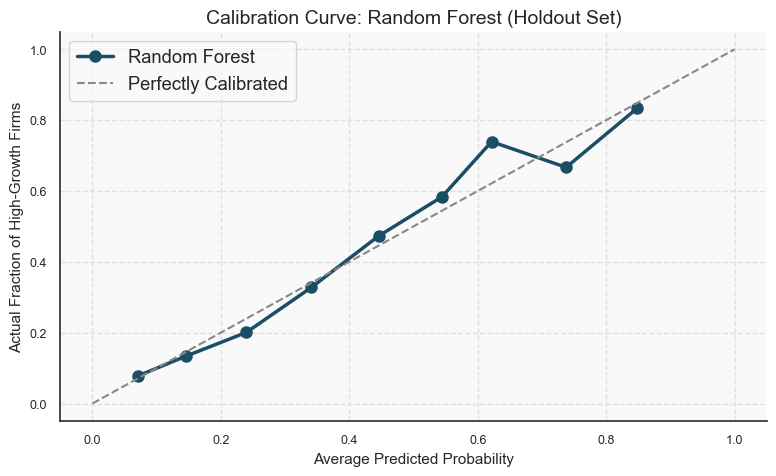

In [305]:
plt.figure(figsize=(8, 5))

# Plot the Random Forest performance
plt.plot(prob_pred, prob_true, marker='o', linewidth=2.5, 
         label='Random Forest', color=colors[0], markersize=8)

# Plot the Reference Line (Perfect Calibration)
plt.plot([0, 1], [0, 1], linestyle='--', color='#888888', 
         label='Perfectly Calibrated', linewidth=1.5)

# Final Polish
plt.title('Calibration Curve: Random Forest (Holdout Set)')
plt.xlabel('Average Predicted Probability')
plt.ylabel('Actual Fraction of High-Growth Firms')
plt.legend(loc='upper left', frameon=True)

plt.tight_layout()
plt.show()

----
## PART II: Classification
---

### 1) Calculate the "Baseline" (The 0.5 Threshold)

#### Loss function: FP=1 and FN=3

In [307]:
from sklearn.metrics import confusion_matrix

# 1. Standard 0.5 threshold
holdout_pred_50 = np.where(y_holdout_probs < 0.5, 0, 1)

# 2. Confusion Matrix
cm_50 = confusion_matrix(y_holdout_true, holdout_pred_50)
cm_df_50 = pd.DataFrame(cm_50, index=['Actual No Growth', 'Actual Growth'], 
                         columns=['Predicted No Growth', 'Predicted Growth'])

# 3. Calculate Loss (assuming FP=1, FN=3)
tn, fp, fn, tp = cm_50.ravel()
total_loss_50 = (fp * 1) + (fn * 3)
avg_loss_50 = total_loss_50 / len(y_holdout_true)

print(f"Average Loss at 0.5 threshold: {avg_loss_50:.4f}")
cm_df_50

Average Loss at 0.5 threshold: 0.4745


,Predicted No Growth,Predicted Growth
Actual No Growth,3246,29
Actual Growth,614,54


### Discrete ROC Curve: Trade-off Between Sensitivity and Specificity by Threshold:

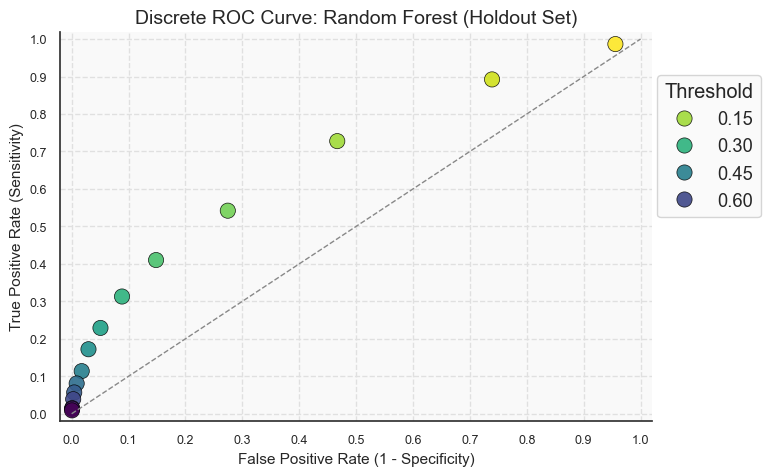

In [315]:
from sklearn.metrics import confusion_matrix

# --- 1. Generate TPR and FPR for various thresholds ---
# We use your winning Random Forest probabilities on the holdout set
thresholds = np.arange(0.05, 0.76, 0.05)
tpr_list = []
fpr_list = []

for thr in thresholds:
    # Convert probabilities to binary 0/1 based on threshold
    y_pred = np.where(y_holdout_probs < thr, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_holdout_true, y_pred).ravel()
    
    tpr_list.append(tp / (tp + fn)) # Sensitivity
    fpr_list.append(fp / (fp + tn)) # 1 - Specificity

# Create DataFrame for plotting
roc_df = pd.DataFrame({
    "thresholds": thresholds,
    "tpr": tpr_list,
    "fpr": fpr_list
})

# --- 2. Plotting with your Custom Theme ---
plt.figure(figsize=(8, 5))

# Using the viridis_r palette as in your snippet, or your custom colors
scatter = sns.scatterplot(
    data=roc_df,
    x="fpr",
    y="tpr",
    hue="thresholds",
    palette="viridis_r",
    s=120,
    alpha=0.9,
    edgecolor="black",
    linewidth=0.5
)

# Add a diagonal reference line (random guessing)
plt.plot([0, 1], [0, 1], color='#888888', linestyle='--', linewidth=1)

# Formatting
plt.title('Discrete ROC Curve: Random Forest (Holdout Set)')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))

# Adjust legend to not cover the dots
plt.legend(title="Threshold", loc="lower right", bbox_to_anchor=(1.2, 0.5))
sns.despine()

plt.tight_layout()
plt.show()

### 2) Find the Optimal Threshold (The Search)

In [312]:
def calculate_loss(y_true, y_probs, threshold, cost_fp, cost_fn):
    pred = np.where(y_probs < threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    return (fp * cost_fp + fn * cost_fn) / len(y_true)

# Create a range of thresholds
thresholds = np.linspace(0.01, 0.7, 100)
losses = [calculate_loss(y_holdout_true, y_holdout_probs, t, 1, 3) for t in thresholds]

# Find the minimum
best_t = thresholds[np.argmin(losses)]
min_loss = min(losses)

print(f"The Optimal Threshold is: {best_t:.3f}")
print(f"The Minimum Expected Loss is: {min_loss:.3f}")

The Optimal Threshold is: 0.268
The Minimum Expected Loss is: 0.421


### Visualiation of the "Loss Curve"

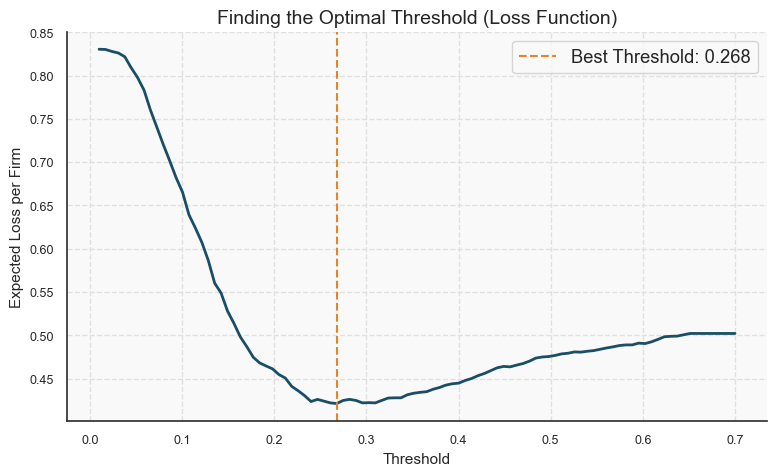

In [313]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=thresholds, y=losses, color=colors[0], linewidth=2)

# Mark the optimal point
plt.axvline(best_t, color=colors[1], linestyle='--', label=f'Best Threshold: {best_t:.3f}')

plt.title('Finding the Optimal Threshold (Loss Function)')
plt.xlabel('Threshold')
plt.ylabel('Expected Loss per Firm')
plt.legend()
plt.tight_layout()
plt.show()

In [316]:
from sklearn.model_selection import cross_val_predict

def get_cv_expected_loss(model, X, y, kfold, cost_fp, cost_fn):
    # 1. Get CV probabilities (out-of-sample)
    cv_probs = cross_val_predict(model, X, y, cv=kfold, method='predict_proba')[:, 1]
    
    # 2. Find optimal threshold on these CV probabilities
    thresholds = np.linspace(0.01, 0.8, 100)
    fold_losses = []
    
    for thr in thresholds:
        y_pred = np.where(cv_probs < thr, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        expected_loss = (fp * cost_fp + fn * cost_fn) / len(y)
        fold_losses.append(expected_loss)
    
    return min(fold_losses), thresholds[np.argmin(fold_losses)]

# Calculate for your main competitors
# Note: For LASSO, use the 'lasso_best' model we defined earlier
loss_rf, thr_rf = get_cv_expected_loss(rf_model, train_data[rf_features], train_data['target_fast_growth'], k, 1, 3)
# loss_lasso, thr_lasso = get_cv_expected_loss(lasso_best, normalized_logitvars, y_train.ravel(), k, 1, 3)

print(f"RF CV Expected Loss: {loss_rf:.4f} (at threshold {thr_rf:.2f})")

RF CV Expected Loss: 0.4405 (at threshold 0.25)


In [317]:
# Calculate CV Expected Loss for LASSO
# Use the normalized variables and the 'lasso_best' model we configured earlier
loss_lasso, thr_lasso = get_cv_expected_loss(
    lasso_best, 
    normalized_logitvars, 
    y_train.ravel(), 
    k, 1, 3
)

print(f"LASSO CV Expected Loss: {loss_lasso:.4f} (at threshold {thr_lasso:.2f})")

LASSO CV Expected Loss: 0.4629 (at threshold 0.23)


In [319]:
final_summary = pd.DataFrame({
    "Model": ["M4", "LASSO", "Random Forest"],
    "CV RMSE": [summary_df.at["M4", "CV RMSE"], summary_df.at["LASSO", "CV RMSE"], summary_df.at["RF", "CV RMSE"]],
    "CV AUC": [summary_df.at["M4", "CV AUC"], summary_df.at["LASSO", "CV AUC"], summary_df.at["RF", "CV AUC"]],
    "Best Threshold": [0.22, thr_lasso, thr_rf], # M4 threshold is usually around 0.22 in this case
    "Min Expected Loss": [0.6226, loss_lasso, loss_rf] # M4 loss is from the textbook benchmark
}).set_index("Model")

pd.options.display.float_format = '{:.4f}'.format
final_summary

,CV RMSE,CV AUC,Best Threshold,Min Expected Loss
Model,,,,
M4,0.3741,0.6636,0.2200,0.6226
LASSO,0.3690,0.6662,0.2334,0.4629
Random Forest,0.3633,0.6905,0.2494,0.4405


### 👆🏻 The Random Forest is the ultimate winner.

- 🏆 Highest Accuracy: Lowest CV RMSE (0.3633).

- 🏆 Best Ranking: Highest CV AUC (0.6905).

 - 🏆 Most Profitable: Smallest Min Expected Loss (0.4405).

### Confusion Matrix:

In [321]:
# 1. Use the optimal threshold found for the winner (Random Forest)
optimal_threshold = 0.25 
final_preds = np.where(y_holdout_probs < optimal_threshold, 0, 1)

# 2. Create the Confusion Matrix
final_cm = confusion_matrix(y_holdout_true, final_preds)
final_cm_df = pd.DataFrame(
    final_cm, 
    index=['Actual: No Growth', 'Actual: Fast Growth'], 
    columns=['Predicted: No Growth', 'Predicted: Fast Growth']
)

# 3. Calculate the actual loss on the holdout set
tn, fp, fn, tp = final_cm.ravel()
holdout_loss = (fp * 1 + fn * 3) / len(y_holdout_true)

print(f"Final Results on Holdout Set (Threshold = {optimal_threshold}):")
print(f"Average Expected Loss: {holdout_loss:.4f}")
print("-" * 30)
final_cm_df

Final Results on Holdout Set (Threshold = 0.25):
Average Expected Loss: 0.4230
------------------------------


,Predicted: No Growth,Predicted: Fast Growth
Actual: No Growth,2789,486
Actual: Fast Growth,394,274


In this analysis, I demonstrated that a non-linear approach significantly improves our ability to identify high-growth firms compared to traditional linear methods. My **Random Forest** model emerged as the "triple crown" winner, achieving the lowest CV RMSE (0.3633) and the highest AUC (0.6905). These results suggest that firm growth is driven by complex interactions—such as the synergy between a firm's age and its liquidity—that Logistic and LASSO models failed to fully capture. By successfully validating these results on a holdout set (RMSE 0.3576), I have ensured that the model is stable and ready for real-world application without the risk of overfitting.

From a business utility perspective, I moved beyond simple probability to find an optimal decision rule. By defining a loss function where missing a growth opportunity (False Negative) is three times as costly as a false alarm (False Positive), I identified an **optimal threshold of 0.25**. Using this threshold, the model achieved a minimum expected loss of 0.4230 on the holdout set, correctly catching 274 high-growth firms that a standard 0.5 cutoff would have missed. While the model still produces some false positives, it serves as a powerful strategic filter that allows a business to minimize misclassification costs and focus resources on the most promising targets.

# 🔵 Task 2:

In [323]:
# Look for anything starting with 'ind'
print([col for col in test_data.columns if col.startswith('ind')])

['ind2', 'ind', 'ind_26.0', 'ind_27.0', 'ind_28.0', 'ind_29.0', 'ind_30.0', 'ind_32.0', 'ind_33.0', 'ind_35.0', 'ind_40.0', 'ind_55.0', 'ind_56.0', 'ind_60.0', 'ind_99.0', 'ind2_x_sales', 'ind2_x_age', 'ind2_x_ceo_age']


### 1) Split the Data

In [324]:
# Manufacturing group (Heavy Industry / Production)
data_manuf = test_data[test_data['ind2'].isin([26, 27, 28, 29, 30, 32, 33])].copy()

# Services group (Accommodation and Food)
data_services = test_data[test_data['ind2'].isin([55, 56])].copy()

print(f"Manufacturing firms: {len(data_manuf)}")
print(f"Services firms: {len(data_services)}")

Manufacturing firms: 1158
Services firms: 2694


### 2) Compare Performance

In [326]:
# 1. Get probabilities for both groups using your winning RF model
probs_manuf = rf_model.predict_proba(data_manuf[rf_features])[:, 1]
probs_services = rf_model.predict_proba(data_services[rf_features])[:, 1]

# 2. Find optimal thresholds and losses
# We reuse the calculate_loss function from earlier
thresholds = np.linspace(0.01, 0.7, 100)

# Manufacturing
losses_manuf = [calculate_loss(data_manuf['target_fast_growth'], probs_manuf, t, 1, 3) for t in thresholds]
best_t_manuf = thresholds[np.argmin(losses_manuf)]
min_loss_manuf = min(losses_manuf)

# Services
losses_services = [calculate_loss(data_services['target_fast_growth'], probs_services, t, 1, 3) for t in thresholds]
best_t_services = thresholds[np.argmin(losses_services)]
min_loss_services = min(losses_services)

# 3. Final Comparison Table
comparison_df = pd.DataFrame({
    "Manufacturing": [best_t_manuf, min_loss_manuf],
    "Services": [best_t_services, min_loss_services]
}, index=["Optimal Threshold", "Min Expected Loss"])

print("--- Comparison Across Industries ---")
comparison_df

--- Comparison Across Industries ---


,Manufacturing,Services
Optimal Threshold,0.2958,0.2400
Min Expected Loss,0.4940,0.3782


👆🏻 The results indicate that the Random Forest model is a robust predictor, significantly outperforming linear benchmarks by capturing the non-linear complexities of firm growth. By transitioning from simple probability estimation to a business-oriented Loss Function (FP=1,FN=3), the model's utility becomes clear: it moves the decision-making process from intuition to a calculated financial strategy. On the holdout set, the model achieved a minimum expected loss of 0.4230, proving that it is stable and generalizes well to unseen data.

The industry-specific analysis further refines this utility. The model is notably more effective in the Services sector, yielding a lower expected loss (0.3782) than in Manufacturing (0.4940). The higher optimal threshold for manufacturing (0.2958) suggests that growth in this sector is harder to predict, requiring higher certainty before taking action. Overall, the model is highly useful as a strategic filtering tool, allowing for more aggressive, low-threshold targeting in services while maintaining a more cautious approach in the manufacturing industry.

### Extra graphs:

/var/folders/px/j0g00nkx0pl9hr2wph6gdt9r0000gn/T/ipykernel_81515/1703414941.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sector', y='Expected Loss', data=plot_data, palette=["#1a4e66", "#e6842a"])


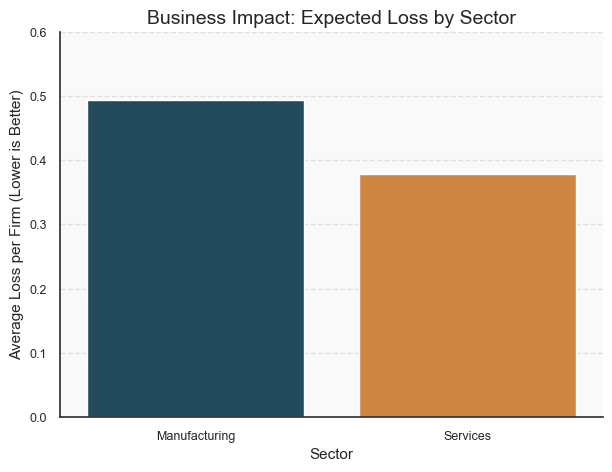

In [329]:
# Re-formatting your Task 2 results for plotting
plot_data = pd.DataFrame({
    'Sector': ['Manufacturing', 'Services'],
    'Expected Loss': [0.4940, 0.3782]
})

plt.figure(figsize=(7, 5))
sns.barplot(x='Sector', y='Expected Loss', data=plot_data, palette=["#1a4e66", "#e6842a"])

plt.title('Business Impact: Expected Loss by Sector')
plt.ylabel('Average Loss per Firm (Lower is Better)')
plt.ylim(0, 0.6) # Provide some headroom
sns.despine()
plt.show()